In [1]:
%pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import cv2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import shutil
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import cv2
import numpy as np
import os
from tqdm.auto import tqdm
import re
import random
from torchmetrics import JaccardIndex
import datetime
jaccard = JaccardIndex(task='binary').to(device)

device

'cpu'

In [12]:
!unzip sun_dataset.zip

Archive:  sun_dataset.zip
   creating: sun_dataset/spot/
  inflating: sun_dataset/spot/20130101.png  
  inflating: sun_dataset/spot/20130102.png  
  inflating: sun_dataset/spot/20130103.png  
  inflating: sun_dataset/spot/20130104.png  
  inflating: sun_dataset/spot/20130105.png  
  inflating: sun_dataset/spot/20130106.png  
  inflating: sun_dataset/spot/20130107.png  
  inflating: sun_dataset/spot/20130108.png  
  inflating: sun_dataset/spot/20130109.png  
  inflating: sun_dataset/spot/20130110.png  
  inflating: sun_dataset/spot/20130111.png  
  inflating: sun_dataset/spot/20130112.png  
  inflating: sun_dataset/spot/20130113.png  
  inflating: sun_dataset/spot/20130114.png  
  inflating: sun_dataset/spot/20130115.png  
  inflating: sun_dataset/spot/20130116.png  
  inflating: sun_dataset/spot/20130117.png  
  inflating: sun_dataset/spot/20130118.png  
  inflating: sun_dataset/spot/20130119.png  
  inflating: sun_dataset/spot/20130120.png  
  inflating: sun_dataset/spot/20130121.png 

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Twice_Conv(nn.Module):
    def __init__(self, in_c, out_c, dropout_prob=0.5):
        super(Twice_Conv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            )
    def forward(self, x):
        return F.dropout(self.conv(x), p=0)


class Down_Layer(nn.Module):
    def __init__(self, in_c, out_c):
        super(Down_Layer, self).__init__()

        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            Twice_Conv(in_c, out_c)
        )

    def forward(self, x):
        return F.dropout(self.down(x), p=0)

class Up_Layer(nn.Module):
    def __init__(self, in_c, out_c):
        super(Up_Layer, self).__init__()

        self.up = nn.ConvTranspose2d(in_c, in_c // 2, kernel_size=2, stride=2)
        self.conv = Twice_Conv(in_c, out_c)
    def forward(self, x1, x2):
        x1 = self.up(x1)     #размер - [размер батча, количество каналов, длина, высота]
        delta_x = x2.shape[2] - x1.shape[2]
        delta_y = x2.shape[3] - x1.shape[3]
        x1 = F.pad(x1, [delta_x // 2, delta_x - delta_x // 2,
                        delta_y // 2, delta_y - delta_y // 2]) # дополняем x1 до x2 чтобы затем объединить их
        return self.conv(torch.cat([x2, x1], dim=1))


class U_Net(nn.Module):
    def __init__(self):
        super(U_Net, self).__init__()

        self.conv = Twice_Conv(3, 64)

        self.conv_down1 = Down_Layer(64, 128)
        self.conv_down2 = Down_Layer(128, 256)
        self.conv_down3 = Down_Layer(256, 512)
        self.conv_down4 = Down_Layer(512, 1024)

        self.conv_up1 = Up_Layer(1024, 512)
        self.conv_up2 = Up_Layer(512, 256)
        self.conv_up3 = Up_Layer(256, 128)
        self.conv_up4 = Up_Layer(128, 64)

        self.last = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.conv_down1(x1)
        x3 = self.conv_down2(x2)
        x4 = self.conv_down3(x3)
        x5 = self.conv_down4(x4)

        out = self.conv_up1(x5, x4)
        out = self.conv_up2(out, x3)
        out = self.conv_up3(out, x2)
        out = self.conv_up4(out, x1)

        return self.last(out)

    def masked_image(self, mask, img): # mask: [600, 600], values: 0 or 1, image: [3, 600, 600]
        binary_mask = mask.copy()
        binary_mask = (mask[:,:] != 1.).astype(np.uint8) * 255 # if mask's value is 0 it's was transform to 255
        result_image = img.copy()
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            result_image = cv2.rectangle((result_image), (x, y), (x + w, y + h), (0, 255, 0), 2)
        return result_image



    def infer(self, x, device=None):
        if device is None:
          device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if isinstance(x, torch.Tensor):
            x = x.to('cpu').numpy()
            if x.shape[-1] != 3:
              x = x.transpose(2, 0, 1)

        if len(x.shape) == 4:
            x = x[0]
        img = x.copy() #image.shape = [600, 600, 3]
        for i in range(600):
            for j in range(600):
                if (300 - i) ** 2 + (300 - j) ** 2 > 290 ** 2:
                    x[i][j] = 126


        gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (11, 11), 0)
        x = np.stack([blurred, blurred, blurred])
        x = torch.from_numpy(x).unsqueeze(0)
        x = x / 255.
        x = x.to(device)

        x1 = self.conv(x)
        x2 = self.conv_down1(x1)
        x3 = self.conv_down2(x2)
        x4 = self.conv_down3(x3)
        x5 = self.conv_down4(x4)

        out = self.conv_up1(x5, x4)
        out = self.conv_up2(out, x3)
        out = self.conv_up3(out, x2)
        out = self.conv_up4(out, x1)
        out = self.last(out)
        out = out.squeeze(0) # [1, 2, 600, 600]  -> [2, 600, 600]
        mask = out.argmax(dim=0)  # mask.shape = [600, 600]
        mask = mask.detach().to('cpu').numpy()

        return self.masked_image(mask, img), mask, out, x


In [15]:

class sun_dataset(Dataset):
    def __init__(self,model, name, sun_folder=None, spot_folder=None, flag=False):
        self.model = model
        self.sun_folder= sun_folder
        super(sun_dataset, self).__init__()
        self.sun_filename = [f for f in os.listdir(sun_folder)] if sun_folder is not None else None

        self.sun_filename = sorted(self.sun_filename, key=lambda x: int(re.sub('\D', '', x)))
        self.sun_filename = self.sun_filename

        # self.sun_data = torch.load('/content/drive/MyDrive/sun/sun_data_tensor.pt')
        # self.sun_data = torch.zeros((len(self.sun_filename), 3, 600, 600))
        # for i, filename in enumerate(tqdm(self.sun_filename)):
        #     name = os.path.join(sun_folder, filename)
        #     img = cv2.imread(name)
        #     self.sun_data[i] = torch.from_numpy(img).permute(2, 0, 1) / 255
        # torch.save(self.sun_data, '/content/drive/MyDrive/sun/sun_data_tensor.pt')
        #self.counter = torch.tensor(self.counter)
        if flag:
            self.spot_mask = torch.zeros(len(self.sun_filename), 600, 600)

            self.spot_folder = [f for f in os.listdir(spot_folder)] if spot_folder is not None else None
            self.spot_folder = sorted(self.spot_folder, key=lambda x: int(re.sub('\D', '', x)))
            self.spot_folder = self.spot_folder
            for i, filename in enumerate(tqdm(self.spot_folder)):
                self.spot_mask[i] = self.get_mask(cv2.imread(os.path.join(spot_folder, filename)), cv2.imread(os.path.join(sun_folder,  self.sun_filename[i])))

            torch.save(self.spot_mask, f'/content/drive/MyDrive/{name}.pt')

        else:
            self.spot_mask = torch.load(spot_folder)
            self.spot_mask = self.spot_mask


    def circle(self, img, radius=300):
        h, w = img.shape[:2]

        mask = np.zeros((h, w), dtype=np.uint8)
        mask = cv2.circle(mask, (w // 2, h // 2), radius, 255, -1)

        img = cv2.bitwise_and(img, img, mask=mask)

        return mask

    def __len__(self):
        return len(self.spot_mask)

    def __getitem__(self, idx):
        name = os.path.join(self.sun_folder, self.sun_filename[idx])
        image = cv2.imread(name)
        for i in range(600):
            for j in range(600):
                if (300 - i) ** 2 + (300 - j) ** 2 > 290 ** 2:
                    image[i][j] = 126
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (11, 11), 0)
        img = np.stack([blurred, blurred, blurred])
        img = torch.from_numpy(img) / 255.
        return img, self.spot_mask[idx]

    def get_mask(self, image, spot):
        res = image.copy()
        high_intensity_pixels = res.mean(axis=2) > 200
        res[high_intensity_pixels] = 255
        res[:60, :125] = res[520:, 520:] = res[575:, :160] = res[:40, 475:] = 255
        window_height = 8
        window_width = 23

        for y in range(0, 600 - window_height + 1, 1):
            for x in range(0, 600 - window_width + 1, 1):
                roi = res[y:y+window_height, x:x+window_width]

                mean_value = roi.mean()

                if 190 <= mean_value <= 215:
                    res[y:y+window_height, x:x+window_width] = 255
        block_size = 10
        self.model.eval()
        mask1 = self.model.infer(spot)[1]
        mask = np.zeros((600, 600, 3)) + 255
        for i in range(0, res.shape[0], block_size):
            for j in range(0, res.shape[1], block_size):
                block = res[i:i+block_size, j:j+block_size]
                block2 = mask1[i:i+block_size, j:j+block_size]
                if block.mean() < 255 and block2.mean() == 0:
                # print(block.mean())
                    mask1[i:i+block_size, j:j+block_size] = 1
                block_size = 20
        for i in range(0, res.shape[0], block_size):
            for j in range(0, res.shape[1], block_size):
                block = res[i:i+block_size, j:j+block_size]
                block2 = mask1[i:i+block_size, j:j+block_size]
                if block.mean() == 255 and block2.mean() != 0:
                    mask1[i:i+block_size, j:j+block_size] = 0
        for i in range(600):
            for j in range(600):
                if (300 - i) ** 2 + (300 - j) ** 2 > 290 ** 2:
                    mask1[i][j] = 0
        return torch.from_numpy(mask1).to(torch.int32)
        #   binary_mask = np.ones((600, 600), dtype=int)

        #   for i in range(600):
        #     for j in range(600):
        #       if mask[i][j][0] == 255:
        #         binary_mask[i][j] = 0
        #   return torch.from_numpy(binary_mask).to(torch.int32)


In [16]:
dataset = sun_dataset(None, 'train_mask_2', 'sun_dataset/sun', 'sun_dataset/train_mask_2.pt', flag=False)
testdataset = sun_dataset(None, 'test_mask_2', 'sun_dataset/sun_test', 'sun_dataset/test_mask_2.pt', flag=False)

In [ ]:
# testdataset = sun_dataset(u_net, 'test_mask_2', '/content/sun_dataset/sun_test', '/content/sun_dataset/spot_test', flag=True)

In [ ]:
# dataset = sun_dataset(u_net, 'train_mask_2', '/content/sun_dataset/sun', '/content/sun_dataset/spot', flag=True)

  0%|          | 0/1995 [00:00<?, ?it/s]

saveing: last_name = 20170209.png, last i = 1499


163 s_20130613.png
890 s_20150610.png
172 s_20130622.png
1124 s_20160130.png
986 s_20150914.png
278 s_20131006.png
1085 s_20151222.png
325 s_20131122.png
598 s_20140822.png


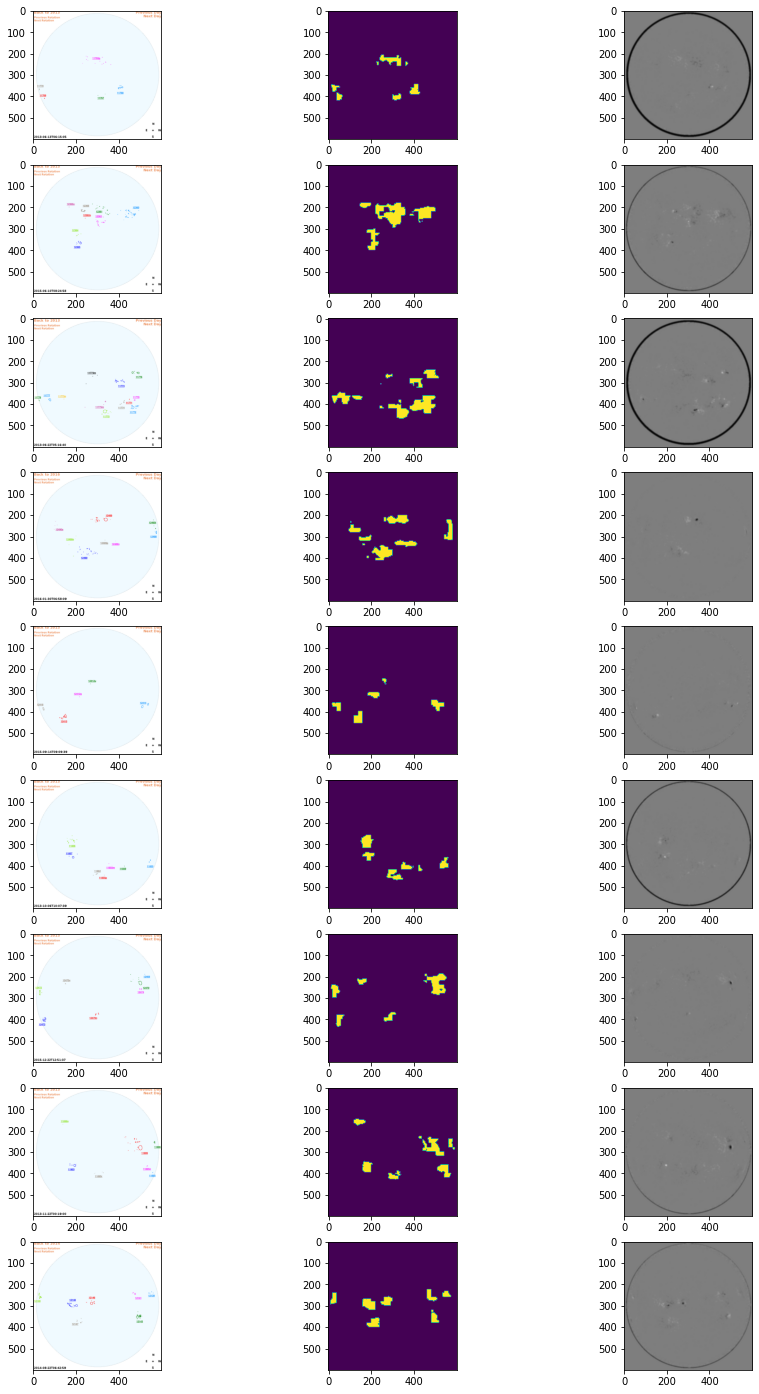

In [17]:
idx = [random.randint(0, 1700) for _ in range(9)]
fig, ax = plt.subplots(9, 3, figsize=(15, 25))
for i, id in enumerate(idx):

    mask = dataset[id][-1]
    img = dataset[id][0]#cv2.imread(os.path.join('/content/sun_dataset/sun', dataset.sun_filename[id]))
    spot = cv2.imread(os.path.join('sun_dataset/spot', dataset.sun_filename[id][2:]))
    #   spot = spot.permute(1, 2, 0).numpy()
    print(id, dataset.sun_filename[id])
    ax[i][0].imshow(spot)
    ax[i][1].imshow(mask.numpy())
    ax[i][2].imshow(img.permute(1, 2, 0).numpy())

In [18]:
u_net = U_Net().to(device)
u_net.load_state_dict(torch.load('sun_dataset/w0_io_0.5197697281837463_loss_0.6144929333873417data2024-03-28 20_20_04.893772.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [49]:
optimizer = torch.optim.Adam(u_net.parameters(), lr=0.0001)
class_weights = torch.tensor([0.03, 0.97]).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

In [24]:
dataloader = DataLoader(dataset, batch_size=20, shuffle=True)
testloader = DataLoader(testdataset, batch_size=16, shuffle=False)
len(dataloader), len(testloader)

(100, 23)

In [22]:
for f in tqdm(os.listdir('sun_dataset/sun')):
    cv2.imread(os.path.join('sun_dataset/sun', f))
for f in tqdm(os.listdir('sun_dataset/sun_test')):
    cv2.imread(os.path.join('sun_dataset/sun_test', f))

100%|██████████| 366/366 [00:01<00:00, 244.49it/s]


100%|██████████| 100/100 [09:27<00:00,  5.67s/it]


Train loss on epoch 0: 0.036924278251826766 Test loss: 0.6803859135378962


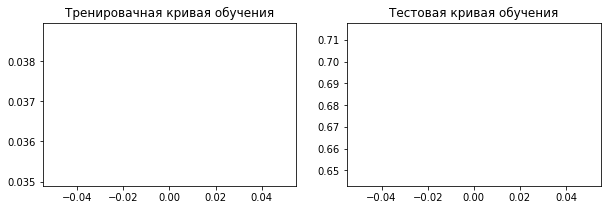

  0%|          | 1/1000 [11:23<189:45:44, 683.83s/it]


KeyboardInterrupt: 

In [50]:
epochs = 1000
u_net.train(True)
loss_list = []
test_loss_list = []
IoU_list = []
test_IoU_list = []
for epoch in tqdm(range(epochs)):
    u_net.train()
    train_loss = 0
    test_loss = 0

    train_IoU = 0
    test_IoU = 0
    for i, batch in enumerate(tqdm(dataloader)):
        optimizer.zero_grad()
        sun, mask = batch[0].to(device), batch[1].to(device).to(torch.long)


        logits = u_net(sun)

        loss = loss_fn(logits, mask)
        loss.backward()
        optimizer.step()

        # sun, mask, loss = sun.to('cpu'), mask.to('cpu'), loss.to('cpu')
        # torch.cuda.empty_cache()
        # train_IoU += jaccard(torch.argmax(logits, dim=1), mask)
        train_loss += loss.item()
        # if (i + 1) % 100 == 0:
        #     print(f'Train loss {train_loss / (i + 1)}')


    u_net.eval()
    with torch.no_grad():
        for batch in testloader:
            test_sun, test_mask = batch[0].to(device), batch[1].to(device).to(torch.long)
            logits = u_net(test_sun)

            loss = loss_fn(logits, test_mask)

            test_loss += loss.item()
            # test_IoU += jaccard(torch.argmax(logits, dim=1), test_mask)




    loss_list.append(train_loss / len(dataloader))
    # IoU_list.append(train_IoU / len(dataloader))
    test_loss_list.append(test_loss / len(testloader))
    # test_IoU_list.append(test_IoU / len(testloader))
    if epoch % 2 == 0:
        print(f'Train loss on epoch {epoch}: {loss_list[-1]} Test loss: {test_loss_list[-1]}')
        # print(f'IoU loss on epoch {epoch}: {IoU_list[-1]} Test IoU loss: {test_IoU_list[-1]}')
        model_path = f"w{epoch}_io_{loss_list[-1]}_loss_{test_loss_list[-1]}data{datetime.datetime.now()}.pth"
        torch.save(u_net.state_dict(), model_path)
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        ax[0].plot(loss_list)
        ax[0].set_title('Тренировачная кривая обучения')
        ax[1].plot(test_loss_list)
        ax[1].set_title('Тестовая кривая обучения')
        plt.show()

